In [1]:
import warnings
from datetime import datetime
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.simplefilter("ignore")

<h3>Final submission notebook with code</h3>

<b>Team: </b>
<ul>
    <li>Mironov Mikhail - mvmironov@edu.hse.ru</li>
</ul>

<p>We have a dedicated Github repository for this project where we have a plethora of other notebooks stored in different branches, there are too many merge conflicts now to pull into a single presentable master branch. This notebook is an aggregation of the best things that we have achieved during the time of the project.</p>

<b>Rundown on the aim of the project</b>

<h4>Data Description</h4>

<p>We have collected data from Binance API. We are using tick level data which is the data containing information about all trades executed for given currency pairs like BTC/USDT and many others. In fact we focused our analysis on currency pairs that are traded against USDT. On our github you can find the code and instructions to run the code to collect tick level data from Binance. In our case it took roughly 20 minutes to download all trades for all currency pairs traded against USDT for November 2024.</p>

<h3>Data pipeline</h3>

<h4>Pipeline to load tick data</h4>
We are downloading compressed zip files from Binance Datavision website which contains aggregated tick data in either daily or monthly chunks. Then after collecting all of the data into its separate folder, we are running the transforming pipeline that unpacks all of the zipped csv files, reads them and discards of the unnecessary fields. Since the compressed csv files are quite big, they could reach the size of 5GB, it is quite hard to fit into the memory in one go and do something with it especially wrap into pd.DataFrame. To solve this issue, we used Polars library that can scan files and do computations in lazy manner, we also applied batching to read csv files in batches of 128 MBs and then dump the data in parquet files with the Hive Dataset structure using Pyarrow. As a result, we have the following folder structure with data on our working machine:

On the first level we have dates, on the second we have tickers, this way we can scan necessary data efficiently and load the data that we need. 

<h4>Feature computation pipeline</h4>

<p>We took cross-sections with all assets traded at the time of each cross-section. Then, we took each cross-section and computed features for each currency_pair within cross-section. We had to use multiprocessing along with Polars to allow us to process more cross-sections as loading and doing calculations with tick level data is quite costly. As a result, we obtained a dataset with the structure below.</p>

In [2]:
df: pd.DataFrame = pd.read_parquet(r"D:\data\features\features_2025-05-13.parquet")

df["cross_section_start_time"] = pd.to_datetime(df["cross_section_start_time"])
df["cross_section_end_time"] = pd.to_datetime(df["cross_section_end_time"])

df.head(5)

,currency_pair,overall_pct_return_FIVE_SECONDS,overall_pct_return_MINUTE,overall_pct_return_FIVE_MINUTES,overall_pct_return_HALF_HOUR,overall_pct_return_HOUR,overall_pct_return_TWO_HOURS,overall_pct_return_FOUR_HOURS,overall_pct_return_EIGHT_HOURS,overall_pct_return_TWELVE_HOURS,...,share_quote_slippage_abs_TWELVE_HOURS_14D,hourly_slippage_zscore_DAY_30D,share_quote_slippage_abs_DAY_14D,hourly_slippage_zscore_THREE_DAYS_30D,share_quote_slippage_abs_THREE_DAYS_14D,hourly_slippage_zscore_WEEK_30D,share_quote_slippage_abs_WEEK_14D,return,cross_section_start_time,cross_section_end_time
0,FORUSDT,0.00047,0.000470,0.000941,0.004247,-0.003279,-0.010233,-0.017997,-0.007000,-0.019355,...,0.028235,-0.096248,0.041117,-0.095570,0.130921,-0.097711,0.249706,0.000000,2024-01-01,2024-01-31
1,DOGEUSDT,0.00000,-0.000502,0.000502,-0.002503,-0.006357,-0.019314,-0.019314,-0.018468,-0.024832,...,0.029834,-0.134893,0.042841,-0.076682,0.182290,-0.145708,0.276579,0.004893,2024-01-01,2024-01-31
2,ONGUSDT,NaN,0.000319,0.000958,-0.003181,-0.009169,-0.013535,-0.018170,-0.016939,-0.018170,...,0.004668,-0.216230,0.008868,-0.215639,0.028272,-0.203420,0.146390,-0.006068,2024-01-01,2024-01-31
3,ANKRUSDT,NaN,-0.000412,0.001237,-0.001234,-0.007761,-0.016997,-0.020169,-0.018586,-0.025281,...,0.010845,-0.188032,0.027703,-0.145324,0.139123,-0.063131,0.576158,-0.008230,2024-01-01,2024-01-31
4,UNFIUSDT,0.00000,-0.001009,0.002023,0.001348,-0.004189,-0.018011,-0.009170,0.003207,-0.005023,...,0.008201,-0.248320,0.012261,-0.217344,0.070490,-0.162641,0.303375,0.013443,2024-01-01,2024-01-31


In [3]:
df.describe().T.head(20)

,count,mean,min,25%,50%,75%,max,std
overall_pct_return_FIVE_SECONDS,41672.0,0.00002,-0.012075,-0.00002,0.0,0.000091,0.02617,0.000757
overall_pct_return_MINUTE,79149.0,0.000167,-0.039123,-0.000394,0.0,0.000623,0.054033,0.001956
overall_pct_return_FIVE_MINUTES,84475.0,-0.000082,-0.11313,-0.001033,0.0,0.001149,0.106057,0.003781
overall_pct_return_HALF_HOUR,84953.0,0.000126,-0.164041,-0.002618,0.000093,0.003231,0.792809,0.010532
overall_pct_return_HOUR,84969.0,0.000455,-0.223026,-0.003657,0.000501,0.005102,0.792809,0.013724
overall_pct_return_TWO_HOURS,84976.0,0.001448,-0.309951,-0.005405,0.000399,0.00675,49.462,0.175002
overall_pct_return_FOUR_HOURS,84982.0,0.003545,-0.260818,-0.007479,0.000946,0.010111,49.462,0.215448
overall_pct_return_EIGHT_HOURS,84992.0,0.007026,-0.307747,-0.009729,0.001959,0.014958,50.884,0.303838
overall_pct_return_TWELVE_HOURS,85002.0,0.010419,-0.38312,-0.011641,0.002709,0.018968,50.884,0.366065
overall_pct_return_DAY,85032.0,0.020689,-0.550135,-0.014373,0.006097,0.030088,50.884,0.511598


In [4]:
df = df.drop_duplicates(subset=["currency_pair", "cross_section_start_time", "cross_section_end_time"])
df = df.reset_index(drop=True)

In [5]:
# if log_return is NaN, therefore there were no transcations during this period of time, hence the return is 0
df["return"] = df["return"].fillna(0)

In [6]:
df.shape

(85734, 96)

<h4>EDA. Check features distributions and search for possible bugs in the data pipeline</h4>

<p>As we can see we have a lot of missing values, the good thing is that it is decreasing in TIME_OFFSET enum that we used to compute features on different intervals. This happens because for non-liquid orderbooks, there were no transactions within smaller intervals like FIVE_SECONDS, TEN_SECONDS and etc, but the good thing that it is decreasing as the interval grows to FIFTEEN_MINUTES which implies that this is just to the lack of transactions not the error in the pipeline</p>

In [7]:
df.isna().sum().sort_values(ascending=False)

slippage_imbalance_FIVE_SECONDS      65037
flow_imbalance_FIVE_SECONDS          44062
overall_pct_return_FIVE_SECONDS      44062
slippage_imbalance_MINUTE            24893
slippage_imbalance_FIVE_MINUTES       6773
                                     ...  
share_quote_slippage_abs_WEEK_14D      108
cross_section_start_time                 0
currency_pair                            0
return                                   0
cross_section_end_time                   0
Length: 96, dtype: int64

In [8]:
reg_cols: List[str] = list(
    set(df.columns) - set(["cross_section_start_time", "cross_section_end_time", "currency_pair", "return"])
)
target_col: str = "return"

In [9]:
powerlaw_cols: List[str] = [col for col in reg_cols if "mle" in col]
return_cols: List[str] = [col for col in reg_cols if col.startswith("overall_pct_return")]
return_cols

['overall_pct_return_TWELVE_HOURS',
 'overall_pct_return_FOUR_HOURS',
 'overall_pct_return_DAY',
 'overall_pct_return_THREE_DAYS',
 'overall_pct_return_WEEK',
 'overall_pct_return_HALF_HOUR',
 'overall_pct_return_TWO_HOURS',
 'overall_pct_return_FIVE_MINUTES',
 'overall_pct_return_FIVE_SECONDS',
 'overall_pct_return_EIGHT_HOURS',
 'overall_pct_return_MINUTE',
 'overall_pct_return_HOUR']

In [10]:
df[reg_cols].describe().T.iloc[20:40]

,count,mean,std,min,25%,50%,75%,max
hourly_slippage_zscore_EIGHT_HOURS_30D,84988.0,0.153441,0.740325,-0.782027,-0.188759,-0.083280,0.167940,8.343331
share_quote_slippage_abs_DAY_14D,85626.0,0.094801,0.108690,0.000000,0.032599,0.061270,0.113965,1.000000
hourly_pct_return_zscore_WEEK_30D,85388.0,0.047295,0.070830,-1.388913,0.000067,0.039717,0.087115,1.486306
overall_pct_return_DAY,85032.0,0.020689,0.511598,-0.550135,-0.014373,0.006097,0.030088,50.884000
hourly_quote_abs_volume_zscore_TWO_HOURS_30D,84972.0,0.230039,1.205727,-1.225026,-0.327414,-0.109040,0.337234,18.835802
hourly_pct_return_zscore_HOUR_30D,84965.0,0.053687,1.244754,-16.233193,-0.376507,0.052182,0.548072,23.153818
hourly_slippage_zscore_HOUR_30D,84965.0,0.152819,1.385636,-0.909182,-0.255925,-0.153610,0.010891,26.559461
share_of_long_trades_THREE_DAYS,85152.0,0.514178,0.048189,0.109305,0.493852,0.513275,0.533686,1.000000
overall_pct_return_THREE_DAYS,85152.0,0.059205,0.874801,-0.563414,-0.015618,0.020043,0.063810,50.884000
mle_alpha_powerlaw_TWO_HOURS,84976.0,inf,NaN,1.053568,1.152923,1.223462,1.329011,inf


In [11]:
# fix infinity alpha_powerlaw features. Clip to quantiles
df[powerlaw_cols] = df[powerlaw_cols].replace(np.inf, np.nan)

for col in powerlaw_cols:
    df[col] = df[col].clip(1, 2)

In [12]:
df[powerlaw_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
mle_alpha_powerlaw_TWO_HOURS,84973.0,1.253009,0.126076,1.053568,1.152922,1.223457,1.328990,2.000000
mle_alpha_powerlaw_DAY,85029.0,1.164606,0.061628,1.053700,1.126146,1.152317,1.186664,2.000000
mle_alpha_powerlaw_HOUR,84963.0,1.285701,0.137140,1.053540,1.171671,1.272342,1.368172,2.000000
mle_alpha_powerlaw_TWELVE_HOURS,84999.0,1.180951,0.079283,1.053656,1.130142,1.161055,1.207993,2.000000
mle_alpha_powerlaw_EIGHT_HOURS,84989.0,1.193916,0.091037,1.053679,1.133299,1.168130,1.226952,2.000000
mle_alpha_powerlaw_THREE_DAYS,85149.0,1.150484,0.044290,1.053860,1.121724,1.143391,1.171091,1.765385
mle_alpha_powerlaw_FOUR_HOURS,84979.0,1.220475,0.109837,1.053494,1.140576,1.186861,1.273927,2.000000
mle_alpha_powerlaw_WEEK,85389.0,1.145466,0.039710,1.054072,1.119533,1.139978,1.165258,1.473690


<h4>Data preprocessing</h4>

<p>Fill in nans in log_return feature with zeros, if there were no trades, hence the return is 0</p>

In [13]:
df[return_cols] = df[return_cols].fillna(0)
df.shape

(85734, 96)

In [14]:
df = df[~(df[return_cols] == 0).all(axis=1)].reset_index(drop=True)
df.shape

(85388, 96)

In [15]:
df = df[df["return"].between(-1, 1)].reset_index(drop=True)
df.shape

(85388, 96)

<p>Apply cross-sectional normalization and add cross-section id</p>

In [17]:
dfs: List[pd.DataFrame] = []

for i, ((_, _), df_cross_section) in enumerate(df.groupby(["cross_section_start_time", "cross_section_end_time"])):
    df_cross_section["cross_section_id"] = i
    dfs.append(df_cross_section)

df: pd.DataFrame = pd.concat(dfs)

6it [00:00,  9.14it/s]


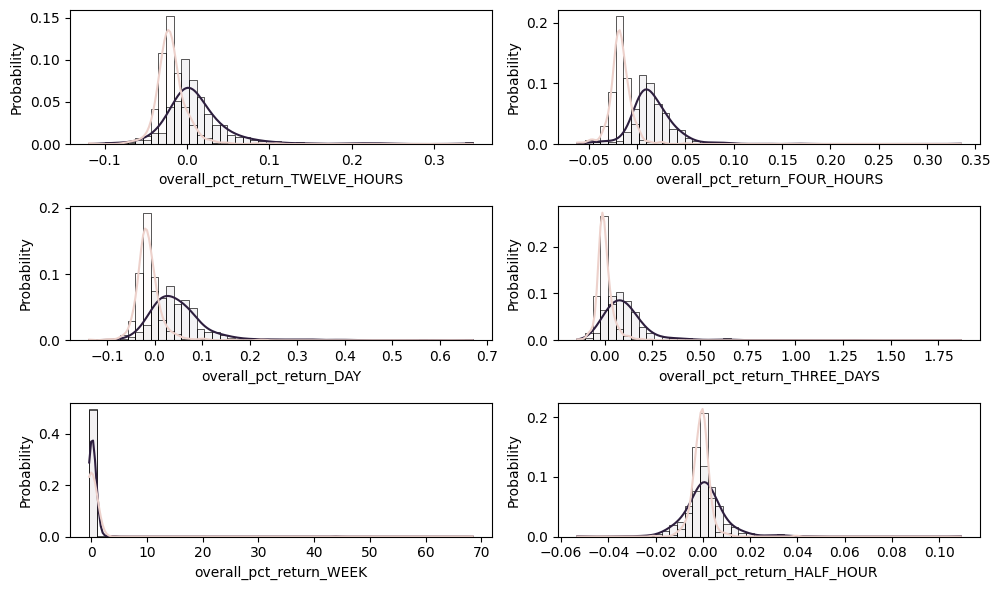

In [18]:
# plot distributions of the data
from tqdm import tqdm

fig, axs = plt.subplots(3, 2, figsize=(10, 6))
axs = axs.flatten()

df_plot = df[df["cross_section_id"].isin([0, 200, 300])].copy()

for ax, col in tqdm(zip(axs, return_cols)):
    sns.histplot(
        data=df_plot, x=col, hue="cross_section_id", ax=ax, legend=False, alpha=0.05, bins=50, kde=True,
        stat="probability"
    )
    # ax.set_xlim([-0.005, 0.005])

plt.tight_layout()
plt.show()

<h4>Apply cross sectional standardization</h4>

$$X_{\text{standardized}} = \frac{X - \bar{X}_{\text{within}}}{\bar{\sigma}(X)_{\text{within}}}$$

In [19]:
dfs: List[pd.DataFrame] = []

for cross_section_id, df_cross_section in tqdm(df.groupby("cross_section_id")):
    for col in reg_cols:
        df_cross_section[col] = (df_cross_section[col] - df_cross_section[col].mean()) / df_cross_section[col].std()
    dfs.append(df_cross_section)

df_scaled: pd.DataFrame = pd.concat(dfs)
df_scaled.head(2)

100%|██████████| 226/226 [00:07<00:00, 32.15it/s]


,currency_pair,overall_pct_return_FIVE_SECONDS,overall_pct_return_MINUTE,overall_pct_return_FIVE_MINUTES,overall_pct_return_HALF_HOUR,overall_pct_return_HOUR,overall_pct_return_TWO_HOURS,overall_pct_return_FOUR_HOURS,overall_pct_return_EIGHT_HOURS,overall_pct_return_TWELVE_HOURS,...,hourly_slippage_zscore_DAY_30D,share_quote_slippage_abs_DAY_14D,hourly_slippage_zscore_THREE_DAYS_30D,share_quote_slippage_abs_THREE_DAYS_14D,hourly_slippage_zscore_WEEK_30D,share_quote_slippage_abs_WEEK_14D,return,cross_section_start_time,cross_section_end_time,cross_section_id
0,FORUSDT,1.177429,0.493322,-0.135755,1.228597,0.659287,0.412907,-0.068095,0.448209,-0.009946,...,0.020780,-0.268747,0.111807,-0.317329,0.14967,-0.787936,0.000000,2024-01-01,2024-01-31,0
1,DOGEUSDT,0.006547,-0.290767,-0.303205,-0.428023,0.133220,-0.578098,-0.183971,-0.359380,-0.296401,...,-0.117485,-0.247374,0.216591,0.073208,-0.20870,-0.645521,0.004893,2024-01-01,2024-01-31,0


<p>First we will setup this problem as the regression type problem</p>

6it [00:01,  5.68it/s]


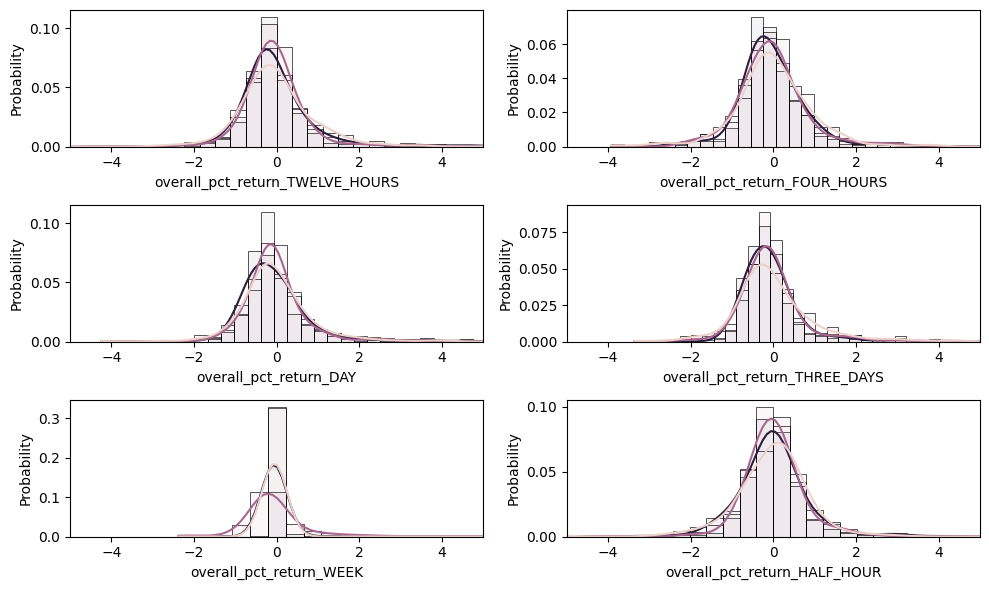

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6))
axs = axs.flatten()

df_plot_scaled = df_scaled[df_scaled["cross_section_id"].isin([0, 100, 200])].copy()

for ax, col in tqdm(zip(axs, return_cols)):
    sns.histplot(
        data=df_plot_scaled,
        x=col, hue="cross_section_id",
        ax=ax, legend=False, alpha=0.05,
        bins=50, kde=True, stat="probability"
    )
    ax.set_xlim([-5, 5])

plt.tight_layout()
plt.show()

<p><b>Result: </b>After applying the cross-sectional standardization, we see that the distributions are more aligned, this allows to fit models regardless of the market conditions as we are looking at features cross-sectionally. This will allow to do splits in trees models more robustly</p>

<h4>Remove obvious outliers in the target</h4>

<p>We will remove all listings from our sample by removing first observation for each currency</p>

In [ ]:
df_scaled = (
    df_scaled
    .sort_values(by="cross_section_start_time", ascending=True)
    .groupby("currency_pair")
    .nth(slice(1, None))
    .reset_index(drop=True)
)

<h3>Modelling</h3>


<h4>Baseline. Regression. Random Forest model</h4>

<p>First we will do RandomForest model, we will do simple train, validation, test in chronological order to make sure that we don't have target leaking due to panel nature of our data</p>

In [21]:
# add additional targets that we will use later before the splits
df_scaled["asset_rank"] = df_scaled.groupby("cross_section_id")["return"].rank(ascending=False)  # ranking target
df_scaled["is_top_5"] = df_scaled["asset_rank"] <= 5  # classification target

In [22]:
df_scaled["cross_section_end_time"].agg(["min", "max"])

min   2024-01-31 00:00:00
max   2024-03-08 12:00:00
Name: cross_section_end_time, dtype: datetime64[ns]

In [23]:
df_scaled["return"].describe()

count    85388.000000
mean         0.002083
std          0.025888
min         -0.260818
25%         -0.007427
50%          0.000883
75%          0.010059
max          0.814225
Name: return, dtype: float64

In [24]:
# train, val, test split
t0: datetime = datetime(2024, 2, 25)
t1: datetime = datetime(2024, 3, 1)

df_train, df_val, df_test = (
    df_scaled[df_scaled["cross_section_end_time"] < t0].copy(),
    df_scaled[df_scaled["cross_section_end_time"].between(t0, t1)].copy(),
    df_scaled[df_scaled["cross_section_end_time"] > t1].copy()
)

(
    df_train["cross_section_id"].nunique(),
    df_val["cross_section_id"].nunique(),
    df_test["cross_section_id"].nunique()
)

(150, 31, 45)

In [25]:
from sklearn.ensemble import RandomForestRegressor
from dataclasses import dataclass
from typing import *


@dataclass
class FeatureSet:
    regressors: List[str]
    target: str
    categorical: Optional[List[str]] = None


# initialize our feature set, that will be used throughtout the notebook
reg_features: FeatureSet = FeatureSet(regressors=reg_cols, target=target_col)

In [26]:
model_rf_base: RandomForestRegressor = RandomForestRegressor(
    max_depth=5,
    max_features="sqrt",
    n_estimators=100,
    criterion="squared_error",
    n_jobs=-1
)

model_rf_base.fit(X=df_train[reg_features.regressors], y=df_train[reg_features.target])

RandomForestRegressor(max_depth=5, max_features='sqrt', n_jobs=-1)

<h4>Visualize results for baseline RandomForest model</h4>

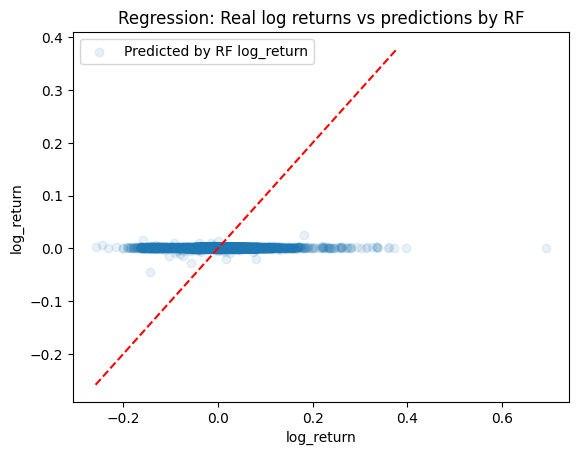

In [27]:
y_pred: np.ndarray = model_rf_base.predict(df_test[reg_features.regressors])

plt.scatter(df_test[target_col], y_pred, label="Predicted by RF log_return", alpha=.1)
x_min, x_max = df_test[target_col].min(), df_val[target_col].max()

X = np.linspace(x_min, x_max, 1000)
plt.plot(X, X, linestyle="--", color="red")

plt.title("Regression: Real log returns vs predictions by RF")
plt.xlabel("log_return")
plt.ylabel("log_return")
plt.legend()

plt.savefig("rf_predictions.png")
plt.show()

<h4>Introduce business eval metric</h4>
<p>It is not easy to interpret metrics like MAE, RMSE. We might want to look at things like SMAPE, MAPE which are more easily interpretable or look at business metrics like PnL</p>

In [28]:
# Implement trading strategy that we will run on the validation and test samples using our trained models
# With prediction of returns it is quite simple, we will invest in top-5 highest return assets and sell 
# them once they are out of 5 best in the next prediction

df_scaled["cross_section_start_time"].is_monotonic_increasing

True

In [29]:
def predict_returns_rf(model: RandomForestRegressor, feature_set: FeatureSet, df: pd.DataFrame) -> np.ndarray:
    """Function that returns predictions for RF regressor model"""
    return model.predict(X=df[feature_set.regressors])

In [30]:
def simple_strategy(df: pd.DataFrame, predicted_returns: np.ndarray) -> np.ndarray:
    dfc: pd.DataFrame = df.copy()
    dfc["predicted_return"] = predicted_returns

    portfolio: set[str] = set([])
    portfolio_returns: List[float] = []

    for cross_section_id, df_cross_section in dfc.groupby("cross_section_id"):
        # Get the list of currency_pairs with the best predicted performance
        best_assets: set[str] = set(
            df_cross_section.sort_values("predicted_return", ascending=False)["currency_pair"].iloc[:10].tolist()
        )
        buy_assets: set[str] = best_assets - portfolio  # assets that we end up buying
        sell_assets: set[str] = portfolio - best_assets  # assets that we are selling when rebalancing
        rebalancing_cost: float = (len(buy_assets) + len(sell_assets)) * 0.1 * 0.00075
        portfolio_return: float = df_cross_section[df_cross_section["currency_pair"].isin(best_assets)]["return"].mean() - rebalancing_cost

        portfolio = best_assets
        portfolio_returns.append(portfolio_return)

    return np.array(portfolio_returns)

In [31]:
rf_pred: np.ndarray = model_rf_base.predict(df_test[reg_features.regressors])

rf_returns: np.ndarray = simple_strategy(df=df_test, predicted_returns=rf_pred)

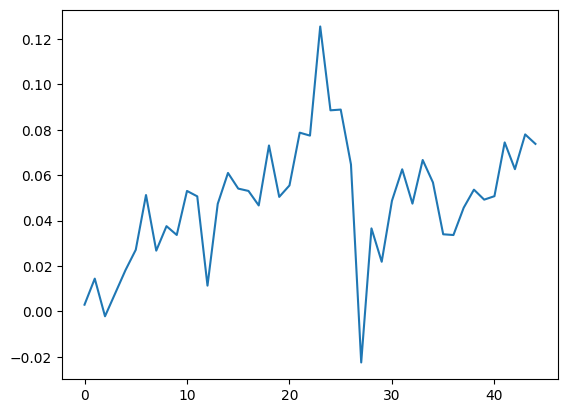

In [33]:
plt.plot(rf_returns.cumsum())
plt.show()

<h4>Regression. CatboostRegressor</h4>

<p>Now attempt to use more complex boosting model in our regression problem. We will not mess around with hyperparameter tuning now, we first want to see if there is any hope for a good result. We will be training CatBoostRegressor with early stopping on a separate validation set with use_best_model flag set yo True which will remove latest <i>early_stopping_rounds</i> trees to the best model specification with highest validation score</p>

In [34]:
from catboost import CatBoostRegressor, Pool

ptrain: Pool = Pool(data=df_train[reg_cols], label=df_train[target_col], cat_features=["currency_pair"])
pval: Pool = Pool(data=df_val[reg_cols], label=df_val[target_col], cat_features=["currency_pair"])
ptest: Pool = Pool(data=df_test[reg_cols], label=df_test[target_col], cat_features=["currency_pair"])

model = CatBoostRegressor(
    objective="RMSE",
    n_estimators=100,
    learning_rate=0.01,
    verbose=False,
    use_best_model=True
)

_ = model.fit(
    ptrain,
    eval_set=pval,
    plot=True,
    early_stopping_rounds=100
)

ValueError: 'currency_pair' is not in list

<h4>Find optimal hyperparameters that optimize RMSE on the validation set</h4>

Since our $f(X, \Theta)$ is not differentiable with respect to hyperparameters and are determined prior to loss optimisation, therefore we need to use Bayesian optimization to minimize our blackbox function on validation sample

In [ ]:
CB_REG_BASE_PARAMS: Dict[str, Any] = {
    "n_estimators": 200,
    "verbose": False,
    "objective": "RMSE",
    "use_best_model": True,
}

In [ ]:
from functools import partial
from sklearn.metrics import root_mean_squared_error
from optuna.study import StudyDirection
from optuna.trial import Trial
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler
from optuna import Study

import optuna


def catboost_regressor_objective(
        trial: Trial, ptrain: Pool, pval: Pool, base_params: Dict[str, Any]
) -> float:
    suggested_params: Dict[str, Any] = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.7, 1),
        "subsample": trial.suggest_float("subsample", 0.7, 1),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
    }
    # Add to base parameters, params suggested by optuna.Trial that minimizes objective -> float:
    model_params: Dict[str, Any] = base_params | suggested_params

    model = CatBoostRegressor(**model_params)
    model.fit(ptrain, eval_set=pval, early_stopping_rounds=50)

    y_pred: np.ndarray = model.predict(pval)
    rmse: float = root_mean_squared_error(y_true=pval.get_label(), y_pred=y_pred)
    return rmse


# Start the search for optimal hyperparams
cb_reg_study: Study = optuna.create_study(
    direction=StudyDirection.MINIMIZE,
    pruner=HyperbandPruner(),
    sampler=TPESampler(),
)

cb_reg_study.optimize(
    partial(catboost_regressor_objective, ptrain=ptrain, pval=pval, base_params=CB_REG_BASE_PARAMS),
    n_trials=5
)

In [ ]:
model_params: Dict[str, Any] = CB_REG_BASE_PARAMS | cb_reg_study.best_params

model_cb_tuned = CatBoostRegressor(**model_params)
model_cb_tuned.fit(ptrain, eval_set=pval, early_stopping_rounds=50, plot=True)

<p>Perhaps we can also adjust min_delta step because nothing much changes with validation RMSE, it still decreases but tiny bit</p>

<h4>Visualize results for CatboostRegressor</h4>

In [ ]:
y_pred: np.ndarray = model_cb_tuned.predict(ptest)

X = np.linspace(df_test[target_col].min(), df_test[target_col].max(), 1000)
plt.plot(X, X, color="red", linestyle="--", label="Real Log return")
plt.scatter(df_test[target_col], y_pred, label="Predicted by CBRegressor log_return")

plt.title("Regression: Real log returns vs predictions by CBRegressor")
plt.xlabel("log_return")
plt.ylabel("log_return")
plt.legend()

plt.tight_layout()
plt.savefig("cb_predictons.png")
plt.show()

<h4>Study feature importances for boosring model</h4>

In [ ]:
df_fi: pd.DataFrame = pd.DataFrame({
    "feature": model_cb_tuned.feature_names_,
    "feature_importance": model_cb_tuned.feature_importances_
}).sort_values(by="feature_importance", ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=df_fi.head(15),
    x="feature_importance",
    y="feature",
    orient="h"
)
plt.tight_layout()
plt.savefig("cb_feature_importances.png")
plt.show()

In [ ]:
cb_pred: np.ndarray = model_cb_tuned.predict(ptest)
cb_returns: np.ndarray = simple_strategy(df=df_test, predicted_returns=cb_pred)

In [ ]:
# Compare Regression models using our simple_strategy
returns: List[np.ndarray] = (rf_returns.cumsum(), cb_returns.cumsum())
models: List[str] = ["RandomForestRegressor", "Tuned CatBoostRegressor"]

for return_series, model_name in zip(returns, models):
    plt.plot(return_series, label=model_name)

plt.title("Comparsion of models in terms of PnL")
plt.legend()

plt.tight_layout()
plt.savefig("pnl_validation.png")
plt.show()

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_pred=cb_pred, y_true=df_test["log_return"])

<h3>Ranking problem</h3>

<p>We might also be willing to be able to predict not the returns themselves but ranking of assets based on their returns.</p>

<h4>CatboostRanker</h4>

<p>We see that high asset_rank corresponds to highest returns within each cross-section. We want a model that can correctly rank assets within each cross-section based on their returns from highest to lowest. So now we are not interested in getting precise values for returns we just want to be able to rank them properly.</p>

In [ ]:
df_train[df_train["asset_rank"] == 1][["asset_rank", "log_return"]].head(5)

<p>To achieve this we will use CatBoostRanker implementation of Ranking models, this is the same boosting technique of estimation of f(x) but now our loss function is not RMSE or MAE that we might have used for regression but NDCG score which measures how correct the set is ranked given true rankings. In our case we will be using YetiRank loss which is just differentiable approximation to NDCG score that can be used in CatboostRanker as the target</p>

In [ ]:
from catboost import CatBoostRanker

ptrain: Pool = Pool(
    data=df_train[reg_cols],
    label=df_train["asset_rank"],
    cat_features=cat_cols,
    group_id=df_train["cross_section_id"]  # define cross_sections 
)

pval: Pool = Pool(
    data=df_val[reg_cols],
    label=df_val["asset_rank"],
    cat_features=cat_cols,
    group_id=df_val["cross_section_id"]
)

model_ranker = CatBoostRanker(
    objective="YetiRankPairwise:mode=NDCG",
    verbose=False,
    use_best_model=True
)

model_ranker.fit(
    ptrain, eval_set=pval, early_stopping_rounds=5, plot=True,
)

In [ ]:
relevance_scores: np.ndarray = model.predict(ptest)

df_test["relevance_scores"] = relevance_scores
df_test["predicted_rank"] = df_test.groupby("cross_section_id")["relevance_scores"].rank(ascending=False)

<h4>Compute PnL using Ranker model</h4>

In [ ]:
returns: List[float] = []

portfolio_returns = []
portfolio = set([])

for cross_section_id, df_cross_section in df_test.groupby("cross_section_id"):
    best_assets: set[str] = set(
        df_cross_section[df_cross_section["predicted_rank"] <= 10]["currency_pair"].tolist()
    )
    buy_assets: set[str] = best_assets - portfolio  # assets that we end up buying
    sell_assets: set[str] = portfolio - best_assets  # assets that we are selling when rebalancing
    rebalancing_cost: float = (len(buy_assets) + len(sell_assets)) * 0.1 * 0.00075
    portfolio_return: float = df_cross_section[df_cross_section["currency_pair"].isin(best_assets)]["log_return"].mean() - rebalancing_cost

    portfolio = best_assets
    portfolio_returns.append(portfolio_return)

ranker_returns: np.ndarray = np.array(portfolio_returns)
plt.plot(ranker_returns.cumsum())
plt.show()

In [ ]:
returns: List[np.ndarray] = [
    rf_returns.cumsum(),
    cb_returns.cumsum(),
    ranker_returns.cumsum()
]
models: List[str] = ["RandomForestRegressor", "Tuned CatBoostRegressor", "CatBoostRanker"]

for return_series, model_name in zip(returns, models):
    plt.plot(return_series, label=model_name)

# plt.plot((1 + df_test[df_test["currency_pair"] == "BTCUSDT"]["log_return"]).cumprod().values)

plt.title("Comparsion of models in terms of PnL")
plt.legend()

plt.tight_layout()
plt.savefig("pnl_validation.png")
plt.show()

In [ ]:
returns: List[np.ndarray] = [
    rf_returns.cumsum(),
    cb_returns.cumsum(),
    ranker_returns.cumsum(),
]

models: List[str] = ["RandomForestRegressor", "Tuned CatBoostRegressor", "CatBoostRanker"]
X = df_test["cross_section_start_time"].unique()

for return_series, model_name in zip(returns, models):
    plt.plot(X[:270], return_series[:270], label=model_name)

plt.plot(
    X[:270],
    df_test[df_test["currency_pair"] == "BTCUSDT"]["log_return"].cumsum().values[:270],
    label="BTC hold"
)

plt.legend()

plt.xticks(rotation=70)
plt.title("Comparsion of models in terms of PnL")
plt.tight_layout()
plt.savefig("pnl_validation.png")
plt.show()

In [ ]:
ranker_returns.mean() / ranker_returns.std() * np.sqrt(365)